In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [91]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=150

In [75]:
datasets = tf.keras.preprocessing.image_dataset_from_directory("dataset",
                                                               seed=123,
                                                               shuffle=True,
                                                               image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE)

Found 8847 files belonging to 18 classes.


In [76]:
datasets.class_names

['burgers',
 'chicken biriyani',
 'chicken pakoda',
 'chicken roll',
 'chicken tandori',
 'chiken curry',
 'chole bhature ',
 'dal fry',
 'dosa',
 'egg curry',
 'fish curry',
 'noodles',
 'paneer curry',
 'pizza',
 'prawn curry',
 'rice',
 'samosa',
 'vada pav']

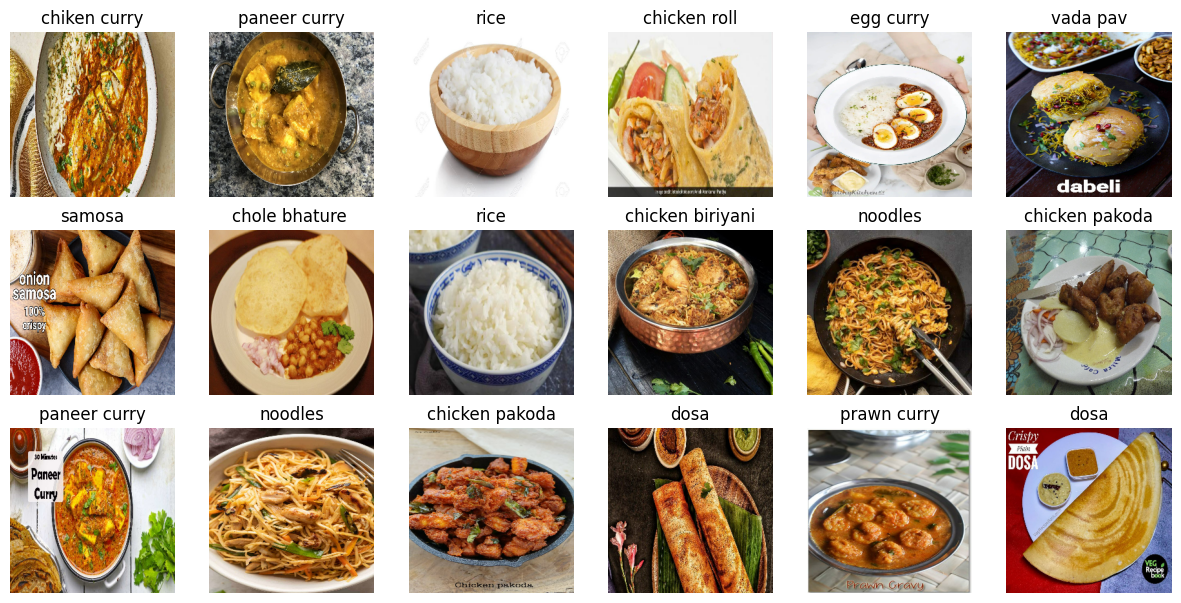

In [77]:
plt.figure(figsize=(15,15))
for image_batch , labels_batch in datasets.take(1):
    for i in range(18):
        ax = plt.subplot(6,6,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labels_batch[i]])
        plt.axis("off")

In [78]:
len(datasets)

277

In [79]:
def get_dataset_partitions_tf(ds, train_split, val_split, test_split, shuffle, shuffle_size):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [80]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(
    datasets,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    shuffle_size=len(datasets)
)

In [81]:
len(train_dataset)

221

In [82]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
    
])

In [85]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [86]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [92]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 18
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [93]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_52 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_52 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (32, 60, 60, 64)        

In [94]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [95]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/150
221/221 [==============================] - 59s 262ms/step - loss: 2.7860 - accuracy: 0.1032 - val_loss: 2.6210 - val_accuracy: 0.1447
Epoch 2/150
221/221 [==============================] - 60s 272ms/step - loss: 2.5930 - accuracy: 0.1640 - val_loss: 2.5033 - val_accuracy: 0.1875
Epoch 3/150
221/221 [==============================] - 66s 298ms/step - loss: 2.4323 - accuracy: 0.2102 - val_loss: 2.3023 - val_accuracy: 0.2500
Epoch 4/150
221/221 [==============================] - 63s 285ms/step - loss: 2.2812 - accuracy: 0.2526 - val_loss: 2.1329 - val_accuracy: 0.2801
Epoch 5/150
221/221 [==============================] - 64s 290ms/step - loss: 2.1162 - accuracy: 0.2930 - val_loss: 2.0426 - val_accuracy: 0.3171
Epoch 6/150
221/221 [==============================] - 72s 325ms/step - loss: 2.0040 - accuracy: 0.3322 - val_loss: 1.9979 - val_accuracy: 0.3461
Epoch 7/150
221/221 [==============================] - 66s 300ms/step - loss: 1.9316 - accuracy: 0.3575 - val_loss: 1.9180 -

Epoch 57/150
221/221 [==============================] - 74s 336ms/step - loss: 0.8821 - accuracy: 0.6991 - val_loss: 0.9475 - val_accuracy: 0.6910
Epoch 58/150
221/221 [==============================] - 72s 326ms/step - loss: 0.8518 - accuracy: 0.7121 - val_loss: 0.8896 - val_accuracy: 0.7095
Epoch 59/150
221/221 [==============================] - 69s 313ms/step - loss: 0.8435 - accuracy: 0.7142 - val_loss: 0.9077 - val_accuracy: 0.7130
Epoch 60/150
221/221 [==============================] - 66s 301ms/step - loss: 0.8489 - accuracy: 0.7155 - val_loss: 0.9673 - val_accuracy: 0.6898
Epoch 61/150
221/221 [==============================] - 66s 299ms/step - loss: 0.8540 - accuracy: 0.7135 - val_loss: 0.9422 - val_accuracy: 0.7014
Epoch 62/150
221/221 [==============================] - 70s 314ms/step - loss: 0.8365 - accuracy: 0.7206 - val_loss: 0.9276 - val_accuracy: 0.6887
Epoch 63/150
221/221 [==============================] - 68s 309ms/step - loss: 0.8210 - accuracy: 0.7271 - val_loss: 0

221/221 [==============================] - 64s 286ms/step - loss: 0.6819 - accuracy: 0.7719 - val_loss: 0.8015 - val_accuracy: 0.7396
Epoch 113/150
221/221 [==============================] - 64s 290ms/step - loss: 0.6704 - accuracy: 0.7697 - val_loss: 0.7808 - val_accuracy: 0.7477
Epoch 114/150
221/221 [==============================] - 64s 288ms/step - loss: 0.6544 - accuracy: 0.7789 - val_loss: 0.8306 - val_accuracy: 0.7384
Epoch 115/150
221/221 [==============================] - 65s 292ms/step - loss: 0.6532 - accuracy: 0.7742 - val_loss: 0.7919 - val_accuracy: 0.7685
Epoch 116/150
221/221 [==============================] - 67s 302ms/step - loss: 0.6645 - accuracy: 0.7721 - val_loss: 0.8223 - val_accuracy: 0.7303
Epoch 117/150
221/221 [==============================] - 69s 313ms/step - loss: 0.6454 - accuracy: 0.7772 - val_loss: 0.8324 - val_accuracy: 0.7338
Epoch 118/150
221/221 [==============================] - 67s 302ms/step - loss: 0.6633 - accuracy: 0.7779 - val_loss: 0.7992 -

In [96]:
model.evaluate(test_dataset) 

29/29 [==============================] - 35s 93ms/step - loss: 0.7670 - accuracy: 0.7619


[0.7669842839241028, 0.7618534564971924]

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [99]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(150), acc, label='Training Accuracy')
plt.plot(range(150), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(150), loss, label='Training Loss')
plt.plot(range(150), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The image to be predict


chole bhature 
1/1 [==============================] - 0s 36ms/step
The Prediction is


chole bhature 


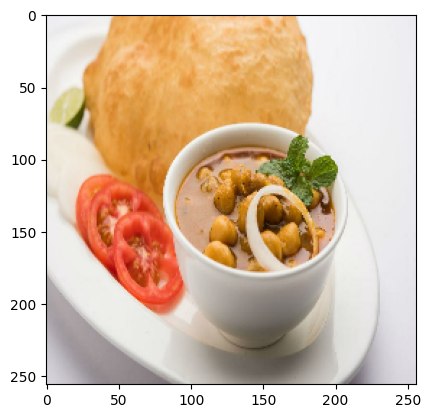

In [124]:
for images_batch , labels_batch in test_dataset.take(1):
    img  = images_batch[2].numpy().astype('uint8')
    label = labels_batch[2].numpy()
    
    print("The image to be predict\n\n")
    print(datasets.class_names[label])
    plt.imshow(img)
    
    
    batch_prediction=model.predict(images_batch)
    print("The Prediction is\n\n")
    print(datasets.class_names[np.argmax(batch_prediction[2])])

In [136]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = md.predict(img_array)

    predicted_class = datasets.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [137]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = datasets.class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 18ms/step


In [134]:
model.save('recipe-classification.h5') #Save Model

In [135]:
md  =  tf.keras.models.load_model('recipe-classification.h5') 

In [ ]:
md.predict()